# 1. Imports

In [1]:
import sys
from pathlib import Path

# Add project root (parent of "electricity") to sys.path

sys.path.append("..")   # go up one level to project root


from electricity.load import Loading
from electricity.preprocessing import Preprocessor


In [2]:
loader = Loading(filepath="complete_dataset.csv", return_X_y=False)

In [3]:
# 3. Load the dataframe
df = loader.load_data()

In [4]:
df

,RRP,school_day,holiday,RRP_t_minus_1,demand_t_minus_1,min_temperature_t_minus_1,max_temperature_t_minus_1,solar_exposure_t_minus_1,rainfall_t_minus_1
date,,,,,,,,,
2015-01-02,33.138988,0,0,25.633696,99635.030,13.3,26.9,23.6,0.0
2015-01-03,34.564855,0,0,33.138988,129606.010,15.4,38.8,26.8,0.0
2015-01-04,25.005560,0,0,34.564855,142300.540,20.0,38.2,26.5,0.0
2015-01-05,26.724176,0,0,25.005560,104330.715,16.3,21.4,25.2,4.2
2015-01-06,31.282311,0,0,26.724176,118132.200,15.0,22.0,30.7,0.0
...,...,...,...,...,...,...,...,...,...
2020-10-02,-6.076028,0,0,34.654671,106641.790,9.4,19.5,21.2,1.8
2020-10-03,-1.983471,0,0,-6.076028,99585.835,12.8,26.0,22.0,0.0
2020-10-04,25.008614,0,0,-1.983471,92277.025,17.4,29.4,19.8,0.0


In [5]:
import numpy as np
import pandas as pd

In [6]:
X = df.drop(columns="RRP")
y = df["RRP"]

In [7]:
type(X)

pandas.core.frame.DataFrame

In [8]:
X.shape

(2105, 8)

In [9]:
# X_train, X_test: (N, T, F) windows for your RNN
# date_array: shape (N, T) with np.datetime64 for each timestep (preferred)
pre = Preprocessor(filepath=".", date_col="date", target_col="RRP")
   # OR: pre.set_rnn_dates(date_feature_index=idx)
pipe = pre.build_pipeline()


In [10]:
pipe

,steps,"[('date_features', ...), ('pre', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,date_col,'date'
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [11]:

pipe.fit(X)      # -> (N, T, F_out)
X_preproc = pipe.transform(X)

:mag_right: CorrelationSelector dropped 6 features: ['pipeline-1__week', 'pipeline-1__dayofyear', 'pipeline-1__week_sin', 'pipeline-1__week_cos', 'pipeline-1__doy_sin', 'pipeline-1__doy_cos']


In [12]:
X_preproc.shape

(2105, 13)

In [13]:
X_preproc

,pipeline-1__school_day,pipeline-1__holiday,pipeline-1__RRP_t_minus_1,pipeline-1__demand_t_minus_1,pipeline-1__min_temperature_t_minus_1,pipeline-1__max_temperature_t_minus_1,pipeline-1__solar_exposure_t_minus_1,pipeline-1__rainfall_t_minus_1,pipeline-1__year,pipeline-1__month,pipeline-1__dayofweek,pipeline-1__month_sin,pipeline-1__month_cos
date,,,,,,,,,,,,,
2015-01-02,-1.0,0.0,-0.725531,-0.973159,0.327869,0.939759,0.868,0.00,-0.666667,-0.833333,0.25,0.288675,0.633975
2015-01-03,-1.0,0.0,-0.592395,0.489688,0.672131,2.373494,1.124,0.00,-0.666667,-0.833333,0.50,0.288675,0.633975
2015-01-04,-1.0,0.0,-0.567101,1.109293,1.426230,2.301205,1.100,0.00,-0.666667,-0.833333,0.75,0.288675,0.633975
2015-01-05,-1.0,0.0,-0.736674,-0.743968,0.819672,0.277108,0.996,5.25,-0.666667,-0.833333,-0.75,0.288675,0.633975
2015-01-06,-1.0,0.0,-0.706187,-0.070334,0.606557,0.349398,1.436,0.00,-0.666667,-0.833333,-0.50,0.288675,0.633975
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-02,-1.0,0.0,-0.565508,-0.631167,-0.311475,0.048193,0.676,2.25,1.000000,0.666667,0.25,-0.500000,0.366025
2020-10-03,-1.0,0.0,-1.288032,-0.975560,0.245902,0.831325,0.740,0.00,1.000000,0.666667,0.50,-0.500000,0.366025
2020-10-04,-1.0,0.0,-1.215434,-1.332294,1.000000,1.240964,0.564,0.00,1.000000,0.666667,0.75,-0.500000,0.366025


In [14]:
df = X_preproc.join(y)

In [15]:
train_size = 0.6
index = round(train_size*df.shape[0])

df_train = df.iloc[:index]
df_test = df.iloc[index:]

In [16]:
df_train.shape

(1263, 14)

In [17]:
from typing import Dict, List, Tuple, Sequence


In [18]:
TARGET = 'RRP'

def get_Xi_yi(
    dataset: pd.DataFrame,
    input_length: int,
    output_length: int,
    random: bool = True,
    start_index: int = None
) -> Tuple[pd.DataFrame]:
    """
    Returns one sequence (X_i, y_i) from the dataset, either randomly or at a specified index.

    Args:
        dataset (pd.DataFrame): The dataset to sample from.
        input_length (int): Length of input sequence.
        output_length (int): Length of output sequence.
        random (bool): If True, select randomly. If False, use start_index.
        start_index (int, optional): If random is False, use this as the starting index.

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (X_i, y_i)
    """
    first_possible_start = 0
    last_possible_start = len(dataset) - (input_length + output_length) + 1

    if last_possible_start <= 0:
        raise ValueError("Not enough data to create a sequence with the given input and output lengths.")

    if random:
        random_start = np.random.randint(first_possible_start, last_possible_start)
    else:
        if start_index is None:
            raise ValueError("start_index must be provided when random is False.")
        if not (first_possible_start <= start_index < last_possible_start):
            raise ValueError(f"start_index must be in [{first_possible_start}, {last_possible_start-1}]")
        random_start = start_index

    X_i = dataset.iloc[random_start:random_start + input_length]
    y_i = dataset.iloc[random_start + input_length:
                      random_start + input_length + output_length][[TARGET]]

    return (X_i, y_i)


def get_X_y(
    dataset: pd.DataFrame,
    input_length: int,
    output_length: int,
    number_of_sequences: int = None,
    random: bool = False
) -> Tuple[np.array]:
    """
    Generate X and y based on the number of desired sequences of the given input_length and output_length.
    If random is False, sequences are taken sequentially to cover the full dataframe (up to number_of_sequences or max possible).
    If number_of_sequences is None, use the maximum possible number of sequences.

    Args:
        dataset (pd.DataFrame): Fold dataframe
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i
        number_of_sequences (int, optional): The number of X_i and y_i pairs to include. If None, use max possible.
        random (bool): If True, sample randomly. If False, sample sequentially.

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y)
    """
    X, y = [], []

    first_possible_start = 0
    last_possible_start = len(dataset) - (input_length + output_length) + 1

    if last_possible_start <= 0:
        raise ValueError("Not enough data to create sequences with the given input and output lengths.")

    max_possible_sequences = last_possible_start

    if number_of_sequences is None:
        n_sequences = max_possible_sequences
    else:
        n_sequences = min(number_of_sequences, max_possible_sequences)

    if random:
        for i in range(n_sequences):
            Xi, yi = get_Xi_yi(dataset, input_length, output_length, random=True)
            X.append(Xi)
            y.append(yi)
    else:
        # Sequential, non-overlapping (or overlapping) windows
        for idx in range(first_possible_start, first_possible_start + n_sequences):
            Xi, yi = get_Xi_yi(dataset, input_length, output_length, random=False, start_index=idx)
            X.append(Xi)
            y.append(yi)

    return np.array(X), np.array(y)

In [19]:
data_train = get_X_y(df_train, 60, 1)
data_test = get_X_y(df_test, 60, 1)

In [20]:
X_train = data_train[0]
y_train = data_train[1]
X_test = data_test[0]
y_test = data_test[1]

In [21]:
y_train

array([[[43.73945714]],

       [[37.25248391]],

       [[25.3228281 ]],

       ...,

       [[74.90558581]],

       [[81.80076688]],

       [[62.27267155]]], shape=(1203, 1, 1))

In [22]:
mean_value = y_train.mean()

In [23]:
mae = sum(abs(y - mean_value) for y in y_test) / len(y_test)
mae

array([[44.57646423]])

In [24]:
# --- Notebook Cell 3: Simple model with unified preprocessing (LinearRegression + TS CV) ---
from electricity.preprocessing import Preprocessor
# Build preprocessing + model pipeline.
# Preprocessor will add date/cyclical features, impute/scale/one-hot, and prune highly correlated features.

In [25]:
import pandas as pd

In [26]:
from electricity.models import _tscv_scores
from sklearn.ensemble import RandomForestRegressor


2025-09-03 12:26:53.822310: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-03 12:26:53.822664: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 12:26:53.869296: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-03 12:26:54.938462: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [27]:
from sklearn.model_selection import TimeSeriesSplit

In [28]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers


In [29]:
from tensorflow.keras.callbacks import EarlyStopping


In [30]:
X_train[0]

array([[-1.00000000e+00,  0.00000000e+00, -7.25531370e-01,
        -9.73158829e-01,  3.27868852e-01,  9.39759036e-01,
         8.68000000e-01,  0.00000000e+00, -6.66666667e-01,
        -8.33333333e-01,  2.50000000e-01,  2.88675135e-01,
         6.33974596e-01,  3.31389876e+01],
       [-1.00000000e+00,  0.00000000e+00, -5.92394503e-01,
         4.89688290e-01,  6.72131148e-01,  2.37349398e+00,
         1.12400000e+00,  0.00000000e+00, -6.66666667e-01,
        -8.33333333e-01,  5.00000000e-01,  2.88675135e-01,
         6.33974596e-01,  3.45648548e+01],
       [-1.00000000e+00,  0.00000000e+00, -5.67100947e-01,
         1.10929288e+00,  1.42622951e+00,  2.30120482e+00,
         1.10000000e+00,  0.00000000e+00, -6.66666667e-01,
        -8.33333333e-01,  7.50000000e-01,  2.88675135e-01,
         6.33974596e-01,  2.50055602e+01],
       [-1.00000000e+00,  0.00000000e+00, -7.36673920e-01,
        -7.43968149e-01,  8.19672131e-01,  2.77108434e-01,
         9.96000000e-01,  5.25000000e+00, -6.

In [31]:
X_train = X_train.astype(np.float32)
y_train  = np.asarray(y_train).astype(np.float32)

X_test = X_test.astype(np.float32)
y_test  = np.asarray(y_test).astype(np.float32)


In [32]:
X_train

array([[[-1.0000000e+00,  0.0000000e+00, -7.2553140e-01, ...,
          2.8867513e-01,  6.3397461e-01,  3.3138988e+01],
        [-1.0000000e+00,  0.0000000e+00, -5.9239453e-01, ...,
          2.8867513e-01,  6.3397461e-01,  3.4564854e+01],
        [-1.0000000e+00,  0.0000000e+00, -5.6710094e-01, ...,
          2.8867513e-01,  6.3397461e-01,  2.5005560e+01],
        ...,
        [ 0.0000000e+00,  0.0000000e+00, -5.3562903e-01, ...,
          5.0000000e-01,  3.6602542e-01,  2.5143131e+01],
        [ 0.0000000e+00,  0.0000000e+00, -7.3423356e-01, ...,
          5.7735026e-01,  1.7930074e-16,  2.4586147e+01],
        [ 0.0000000e+00,  0.0000000e+00, -7.4411392e-01, ...,
          5.7735026e-01,  1.7930074e-16,  3.3166527e+01]],

       [[-1.0000000e+00,  0.0000000e+00, -5.9239453e-01, ...,
          2.8867513e-01,  6.3397461e-01,  3.4564854e+01],
        [-1.0000000e+00,  0.0000000e+00, -5.6710094e-01, ...,
          2.8867513e-01,  6.3397461e-01,  2.5005560e+01],
        [-1.0000000e+00, 

In [33]:
es = EarlyStopping(patience=10, restore_best_weights=True)
model = Sequential()
model.add(layers.LSTM(units=100, return_sequences=True))
model.add(layers.LSTM(units=100))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dense(1, activation="linear"))
model.compile(loss="mse", optimizer="adam", metrics=["mae"])
history = model.fit(X_train, y_train, epochs=1000, callbacks=[es], validation_split=0.2, batch_size=32, verbose=1)

Epoch 1/1000


2025-09-03 12:26:55.482327: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 4148.3477 - mae: 51.0049 - val_loss: 12714.1094 - val_mae: 67.1762
Epoch 2/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1730.4897 - mae: 30.6414 - val_loss: 9139.9785 - val_mae: 32.4560
Epoch 3/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1497.6227 - mae: 29.1868 - val_loss: 9382.9883 - val_mae: 35.5903
Epoch 4/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1174.5450 - mae: 23.4380 - val_loss: 8300.8770 - val_mae: 23.7582
Epoch 5/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 702.3187 - mae: 15.2192 - val_loss: 7956.0054 - val_mae: 22.8576
Epoch 6/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 634.0330 - mae: 13.5954 - val_loss: 7930.3174 - val_mae: 21.8817
Epoch 7/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 615.3781 - mae: 13.2254 - val_loss: 7790.2222 - val_mae: 23.1501
Epoch 8/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 594.8061 - mae: 13.0773 - val_loss: 7774.5269 - val_mae: 23.7812


In [34]:
def calculate_aic(model, X, y_true):
    """
    Calculate AIC for a trained Keras regression model.
    """
    # Predictions
    y_pred = model.predict(X, verbose=0).reshape(-1)
    y_true = y_true.reshape(-1)

    n = len(y_true)  # number of samples
    k = np.sum([K.count_params(w) for w in model.trainable_weights])  # number of params

    # Residual Sum of Squares
    rss = np.sum((y_true - y_pred) ** 2)

    # AIC formula for Gaussian likelihood
    aic = n * np.log(rss / n) + 2 * k
    return aic

In [35]:
from tensorflow.keras import regularizers
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10, restore_best_weights=True)

model = Sequential()

# First LSTM layer with dropout + L2 regularization + batch norm
model.add(layers.LSTM(
    units=100,
    return_sequences=True,
    kernel_regularizer=regularizers.l2(0.001)
))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Second LSTM layer
model.add(layers.LSTM(
    units=100,
    kernel_regularizer=regularizers.l2(0.001)
))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Dense layers with regularization + batch norm
model.add(layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(50, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Output layer
model.add(layers.Dense(1, activation="linear"))

# Compile
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

# Train
history = model.fit(
    X_train, y_train,
    epochs=1000,
    callbacks=[es],
    validation_split=0.2,
    batch_size=32,
    verbose=1
)


Epoch 1/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 4840.8228 - mae: 59.5175 - val_loss: 17138.9531 - val_mae: 94.5743
Epoch 2/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4589.2314 - mae: 59.0701 - val_loss: 16886.2598 - val_mae: 93.2999
Epoch 3/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 4430.6011 - mae: 58.5480 - val_loss: 16899.7559 - val_mae: 93.4479
Epoch 4/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 4278.5645 - mae: 57.9633 - val_loss: 16312.6318 - val_mae: 90.3302
Epoch 5/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 4114.4409 - mae: 57.1837 - val_loss: 16002.4424 - val_mae: 88.7910
Epoch 6/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 3935.3181 - mae: 56.2399 - val_loss: 15419.4189 - val_mae: 85.7037
Epoch 7/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 3777.6689 - mae: 55.1852 - val_loss: 14131.3164 - val_mae: 77.8579
Epoch 8/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 3617.8589 - mae: 54.0972 - val_loss: 13798.

In [36]:
model.evaluate(X_test, y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 39974.1953 - mae: 36.0072


[39974.1953125, 36.00721740722656]

In [37]:
import matplotlib.pyplot as plt

In [38]:
y_pred = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


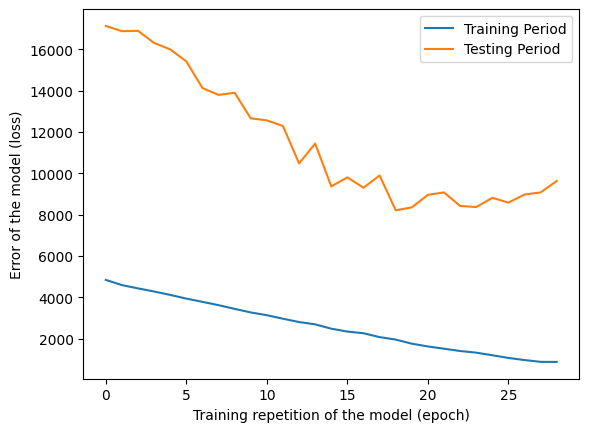

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history.get('val_loss'))
plt.legend(['Training Period','Testing Period'])
plt.xlabel('Training repetition of the model (epoch)')
plt.ylabel('Error of the model (loss)')
plt.show()

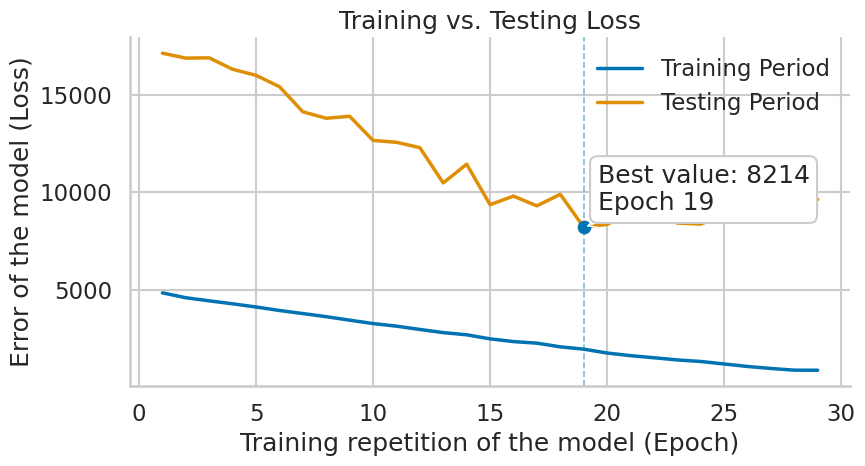

In [52]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data from your Keras History object
train_loss = np.asarray(history.history["loss"], dtype=float)
val_loss   = history.history.get("val_loss", None)

epochs = np.arange(1, len(train_loss) + 1)

# Seaborn aesthetics
sns.set_theme(style="whitegrid", context="talk", palette="colorblind")

fig, ax = plt.subplots(figsize=(9, 5))

# Lines
sns.lineplot(x=epochs, y=train_loss, label="Training Period", linewidth=2.5, ax=ax)
if val_loss is not None:
    val_loss = np.asarray(val_loss, dtype=float)
    sns.lineplot(x=epochs[:len(val_loss)], y=val_loss, label="Testing Period", linewidth=2.5, ax=ax)

    # Mark best validation epoch
    best_idx = int(np.nanargmin(val_loss))
    ax.scatter(epochs[best_idx], val_loss[best_idx], s=70, zorder=3)
    ax.axvline(epochs[best_idx], ls="--", lw=1.2, alpha=0.5)
    ax.annotate(
        f"Best value: {val_loss[best_idx]:.4g}\nEpoch {epochs[best_idx]}",
        xy=(epochs[best_idx], val_loss[best_idx]),
        xytext=(10, 12), textcoords="offset points",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.8"),
        arrowprops=dict(arrowstyle="->", lw=1)
    )

# Labels & layout
ax.set_title("Training vs. Testing Loss")
ax.set_xlabel("Training repetition of the model (Epoch)")
ax.set_ylabel("Error of the model (Loss)")
ax.legend(title=None, frameon=False, loc="upper right")
sns.despine()
fig.tight_layout()
plt.show()


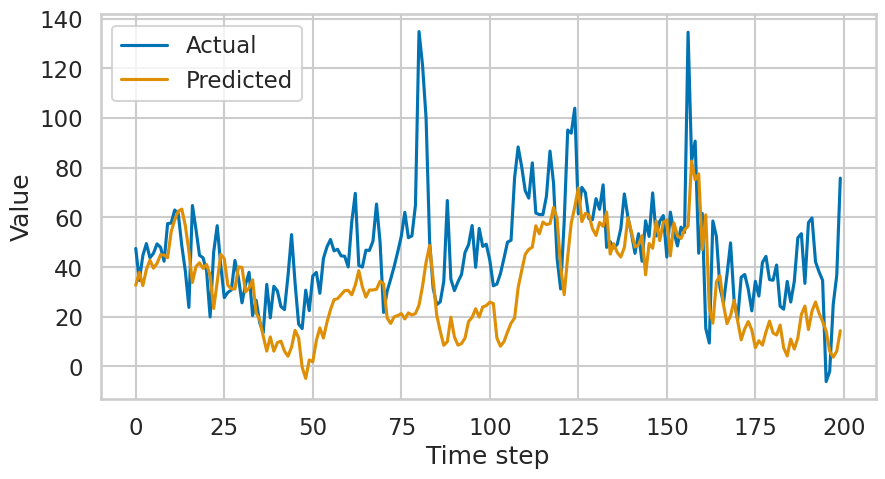

In [41]:
y_true = np.array(y_test).reshape(-1)[-200:]
y_hat  = np.array(y_pred).reshape(-1)[-200:]

plt.figure(figsize=(10,5))
plt.plot(y_true, label="Actual")
plt.plot(y_hat, label="Predicted")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.legend()
plt.show()

In [42]:
model.save('rnn_model.keras')

In [43]:
model.save('rnn_model.h5')

In [44]:
model = tf.keras.models.load_model('rnn_model.keras')

In [45]:
model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


array([[78.04474  ],
       [72.5255   ],
       [42.793625 ],
       [58.004814 ],
       [79.16054  ],
       [85.0101   ],
       [85.542816 ],
       [81.99121  ],
       [84.1765   ],
       [89.31909  ],
       [88.2843   ],
       [88.30658  ],
       [91.280045 ],
       [90.1658   ],
       [84.93468  ],
       [89.413055 ],
       [87.064804 ],
       [92.40726  ],
       [93.63364  ],
       [90.69835  ],
       [89.05376  ],
       [92.529526 ],
       [94.92122  ],
       [90.45729  ],
       [75.448425 ],
       [83.23007  ],
       [70.11313  ],
       [76.94797  ],
       [77.371155 ],
       [40.118187 ],
       [32.250504 ],
       [66.44713  ],
       [68.21927  ],
       [75.55003  ],
       [82.12407  ],
       [88.213974 ],
       [88.36522  ],
       [80.936005 ],
       [79.75874  ],
       [84.033905 ],
       [89.131775 ],
       [91.11229  ],
       [86.94928  ],
       [84.54147  ],
       [83.17546  ],
       [83.60358  ],
       [88.435    ],
       [88.01

In [46]:
from fastapi import FastAPI

app = FastAPI()


In [47]:
@app.get('/')
def index():
    return {'ok': True, "message": "Model API is running 🚀"}

In [48]:
type(X_test)

numpy.ndarray

In [49]:
np.save("my_x.npy", X_test)


In [50]:
y_test

array([[[ 7.76177673e+01]],

       [[ 3.83011475e+01]],

       [[ 5.04469490e+01]],

       [[ 1.02338814e+02]],

       [[ 1.19228432e+02]],

       [[ 1.04816162e+02]],

       [[ 8.95793686e+01]],

       [[ 9.74678421e+01]],

       [[ 1.18487839e+02]],

       [[ 1.05462212e+02]],

       [[ 1.05011803e+02]],

       [[ 1.19823074e+02]],

       [[ 1.18379013e+02]],

       [[ 9.71664200e+01]],

       [[ 1.22425995e+02]],

       [[ 1.04026062e+02]],

       [[ 1.37131516e+02]],

       [[ 1.39516388e+02]],

       [[ 1.19574341e+02]],

       [[ 1.11540756e+02]],

       [[ 1.38907532e+02]],

       [[ 1.61506821e+02]],

       [[ 1.09293770e+02]],

       [[ 6.76155930e+01]],

       [[ 9.26159821e+01]],

       [[ 6.73332520e+01]],

       [[ 8.36948929e+01]],

       [[ 8.49782791e+01]],

       [[ 3.52242622e+01]],

       [[ 1.46735878e+01]],

       [[ 8.16376190e+01]],

       [[ 7.06853027e+01]],

       [[ 8.54524689e+01]],

       [[ 1.01004051e+02]],

       [[ 1.15

In [51]:
import numpy as np
y = np.asarray(y_test).squeeze()         # -> shape (N,)
np.save("y_test.npy", y.astype("float32"))
